In [23]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import open3d as o3d
import torch
import tqdm
from diffusers import StableDiffusionPipeline

from IPython.display import Image


In [24]:
base_path = Path('../Dataset/')
metadata = pd.read_csv(base_path/'metadata_modelnet40.csv')
dataset_dir = base_path/'ModelNet40'

In [57]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ('Not a valid OFF header')
    n_verts, n_faces, __ = tuple(
        [int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')]
             for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:]
             for i_face in range(n_faces)]
    return verts, faces


# read in data
sample_label = 'airplane'
with open(f'{dataset_dir}/{sample_label}/train/{sample_label}_0001.off', 'r') as f:
    verts, faces = read_off(f)

In [5]:
# generate texture image
pipe = StableDiffusionPipeline.from_pretrained('../SavedPretrainedModel/texture_diffusion', torch_dtype=torch.float32)
pipe.enable_attention_slicing()
# pipe = StableDiffusionPipeline.from_pretrained('dream-textures/texture-diffusion', torch_dtype=torch.float32)
# pipe.save_pretrained('../SavedPretrainedModel/texture_diffusion')
# pipe = pipe.to('cuda')

100%|██████████| 50/50 [11:53<00:00, 14.27s/it]


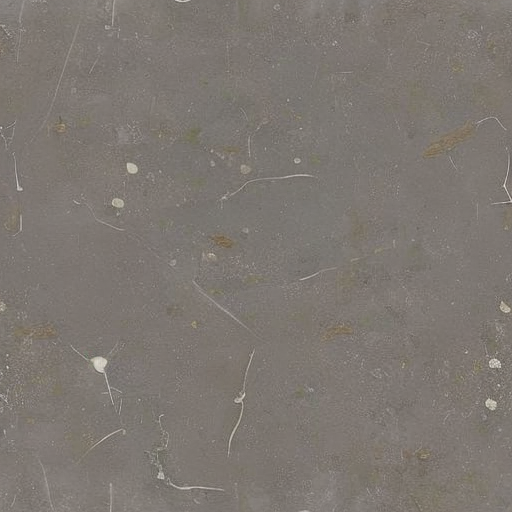

In [12]:
# display brick texture
prompt = f'pbr bright white marble'
images = pipe(prompt).images

# select a random texture image
image_idx = np.random.choice(len(images))
image_path = '../Texture/' + prompt.replace(' ', '_') + '.png'
images[image_idx].save(image_path)
Image(filename=image_path)


In [61]:
labels = list({0: 'airplane',
 1: 'bed',
 2: 'bench',
 3: 'bookshelf',
 4: 'bottle',
 5: 'bowl',
 6: 'car',
 7: 'chair',
 8: 'cone',
 9: 'cup',
 10: 'curtain',
 11: 'door',
 12: 'guitar',
 13: 'keyboard',
 14: 'lamp',
 15: 'laptop',
 16: 'mantel',
 17: 'person',
 18: 'piano',
 19: 'plant',
 20: 'radio',
 21: 'sink',
 22: 'stairs',
 23: 'stool',
 24: 'tent',
 25: 'toilet',
 26: 'vase',
 27: 'wardrobe',
 28: 'xbox'}.values())

In [67]:
for label in labels:
    prompt = f'pbr {label}'
    image_path = '../Texture/' + prompt.replace(' ', '_') + '.png'
    if os.path.exists(image_path):
        continue
    print(prompt)
    images = pipe(prompt).images
    images[0].save(image_path)
    Image(filename=image_path)


pbr bed


100%|██████████| 50/50 [11:58<00:00, 14.36s/it]


pbr bench


100%|██████████| 50/50 [12:35<00:00, 15.12s/it]


pbr bookshelf


100%|██████████| 50/50 [12:54<00:00, 15.48s/it]


pbr bottle


100%|██████████| 50/50 [12:45<00:00, 15.30s/it]


pbr bowl


100%|██████████| 50/50 [12:32<00:00, 15.04s/it]


pbr car


100%|██████████| 50/50 [12:33<00:00, 15.07s/it]


pbr chair


100%|██████████| 50/50 [12:35<00:00, 15.10s/it]


pbr cone


100%|██████████| 50/50 [12:40<00:00, 15.21s/it]


pbr cup


100%|██████████| 50/50 [12:39<00:00, 15.20s/it]


pbr curtain


100%|██████████| 50/50 [12:41<00:00, 15.22s/it]


pbr door


100%|██████████| 50/50 [12:41<00:00, 15.23s/it]


pbr guitar


 12%|█▏        | 6/50 [01:26<10:38, 14.51s/it]

In [63]:
def generate_texture_coords(verts, faces, texture_file):
    texture = cv2.imread(texture_file, cv2.COLOR_BGR2RGB)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
    triangles_uv = []
    for face in faces:
        v1, v2, v3 = verts[face[0]], verts[face[1]], verts[face[2]]
        uv1 = [v1[0] / texture.shape[1], v1[1] / texture.shape[0]]
        uv2 = [v2[0] / texture.shape[1], v2[1] / texture.shape[0]]
        uv3 = [v3[0] / texture.shape[1], v3[1] / texture.shape[0]]
        triangles_uv.extend([uv1, uv2, uv3])
        
    triangles_uv = np.array(triangles_uv)

    return texture, triangles_uv


prompt = f'pbr {sample_label}'
image_path = '../Texture/' + prompt.replace(' ', '_') + '.png'
# image_path = r'..\Texture\pbr_brick_wall.png'
texture, triangles_uv = generate_texture_coords(verts, faces, image_path)
# normalize the texture coordinates to the range [0, 1]
triangles_uv = (triangles_uv - np.min(triangles_uv, axis=0)) / (np.max(triangles_uv, axis=0) - np.min(triangles_uv, axis=0))

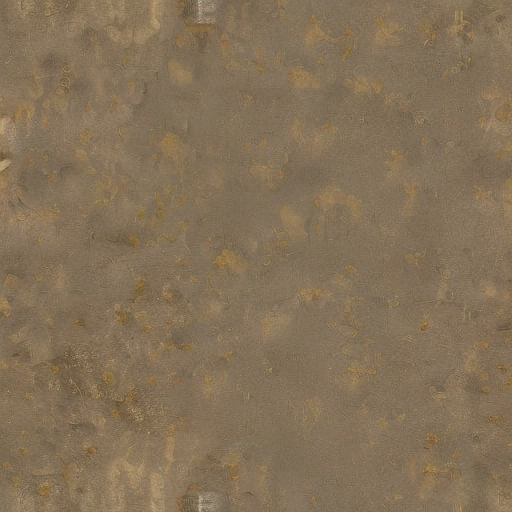

In [65]:
Image(filename=image_path)

In [66]:
m = o3d.geometry.TriangleMesh(o3d.open3d.utility.Vector3dVector(verts),
                              o3d.open3d.utility.Vector3iVector(faces))
m.compute_vertex_normals()
m.triangle_uvs = o3d.open3d.utility.Vector2dVector(triangles_uv)
m.triangle_material_ids = o3d.utility.IntVector([0]*len(faces))
m.textures = [o3d.geometry.Image(texture)]

o3d.visualization.draw_geometries([m])